# Fit energies and forces (full cycle)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import torch
sys.path.append(os.path.expandvars("/home/$USER/repos/fande/"))

In [2]:
from ase import io

traj_295 = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index=":")
traj_355 = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_355_355K/md_trajectory.traj", index=":")

traj_295_2000K = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_295_2000K/md_trajectory.traj", index=":")
traj_355_2000K = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_355_2000K/md_trajectory.traj", index=":")
traj_295_2000K_forced = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_295_2000K_0075force/md_trajectory.traj", index=":")
traj_355_2000K_forced = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_355_2000K_0075force/md_trajectory.traj", index=":")


In [3]:
trajectory_forces = traj_295_2000K[0:5000:10]
trajectory_forces = trajectory_forces[0::10].copy()

trajectory_energy = traj_295[0:5000] + traj_355[0:5000] + traj_295_2000K[0:5000] + traj_355_2000K[0:5000] + traj_295_2000K_forced[0:5000] + traj_355_2000K_forced[0:5000]
# trajectory_energy = traj_295 + traj_295_2000K + traj
trajectory_energy = trajectory_energy[::10].copy()

print(len(trajectory_forces), len(trajectory_energy))

50 3000


In [4]:
from fande.data import FandeDataModule
from fande.utils.find_atomic_groups import find_atomic_groups


soap_params = dict(soap_type="PowerSpectrum",
        interaction_cutoff=3.0,
        max_radial=3,
        max_angular=3,
        gaussian_sigma_constant=0.3,
        gaussian_sigma_type="Constant",
        cutoff_function_type="RadialScaling",
        cutoff_smooth_width=0.1, # 0.1 is way better than 0.5
        cutoff_function_parameters=
                dict(
                        rate=1,
                        scale=3.5,
                        exponent=4
                        ),
        radial_basis="GTO",
        normalize=True, # setting False makes model untrainable
        #   optimization=
        #         dict(
        #                 Spline=dict(
        #                    accuracy=1.0e-05
        #                 )
        #             ),
        compute_gradients=True, # for energies gradients are ignored
        expansion_by_species_method='structure wise'
        )
##FOR NOW USE THE SAME SOAP PARAMETERS FOR ENERGY AND FORCES! (that makes sense if you're modeling the MD)

sample_snapshot = trajectory_forces[0].copy()
fdm = FandeDataModule()
atomic_groups = find_atomic_groups(sample_snapshot)
train_centers_positions = sum(atomic_groups, []) #list(range(len(atoms)))
train_derivatives_positions = sum(atomic_groups, [])#list(range(len(atoms)))
fdm.atomic_groups_sample_snapshot = sample_snapshot.copy()
fdm.atomic_groups = atomic_groups

total_forces_samples_per_group = [3000] * len(atomic_groups)
high_forces_samples_per_group = [0] * len(atomic_groups)

fande.models module imported...
Total number of found groups: 14
Checking if all atoms are covered:  True


In [5]:
dataloader_energy, dataloaders_forces = fdm.dataloaders_from_trajectory(
                                                                trajectory_energy,
                                                                trajectory_forces,
                                                                # energies = None,
                                                                # forces = None,
                                                                atomic_groups = atomic_groups,
                                                                centers_positions = train_centers_positions,
                                                                derivatives_positions = train_derivatives_positions,
                                                                energy_soap_hypers = soap_params,
                                                                forces_soap_hypers = soap_params,
                                                                total_forces_samples_per_group = total_forces_samples_per_group,
                                                                high_force_samples_per_group = high_forces_samples_per_group,
                                                                )

Total length of traj is 3000
Total number of batches 3000
Calculating invariants on trajectory with librascal...


100%|██████████| 3000/3000 [01:21<00:00, 36.71it/s]


invariants for energy fitting calculated


100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


invariants for forces fitting calculated
torch.Size([3000, 540])
torch.Size([3000])
Taking ALL 1800 samples for group 0
Dataloader for group 0 created
Number of samples in dataloader: 1800
Dataloader for group 1 created
Number of samples in dataloader: 3000
Dataloader for group 2 created
Number of samples in dataloader: 3000
Taking ALL 1800 samples for group 3
Dataloader for group 3 created
Number of samples in dataloader: 1800
Taking ALL 1800 samples for group 4
Dataloader for group 4 created
Number of samples in dataloader: 1800
Dataloader for group 5 created
Number of samples in dataloader: 3000
Dataloader for group 6 created
Number of samples in dataloader: 3000
Dataloader for group 7 created
Number of samples in dataloader: 3000
Dataloader for group 8 created
Number of samples in dataloader: 3000
Dataloader for group 9 created
Number of samples in dataloader: 3000
Taking ALL 1800 samples for group 10
Dataloader for group 10 created
Number of samples in dataloader: 1800
Dataloader 

In [10]:
# Making energy model

from fande.models import EnergyModel

hparams = {
        'dtype' : 'float32',
        'device' : 'gpu',
        'energy_model_hparams' : {
                'model_type' : 'variational_inducing_points',#'variational_inducing_points', 'exact'
                'num_inducing_points' : 1000,
                'num_epochs' : 1_000,
                'learning_rate' : 0.01,
        }
        }
       
Energy_model = EnergyModel(
        dataloader_energy,
        hparams=hparams)

Energy_model.fit()

ModuleNotFoundError: No module named 'fande'

In [9]:
import torch
torch.randint(low=0, high=10, size=(5,))

perm = torch.randperm(tensor.size(0))
idx = perm[:k]

tensor([2, 3, 3, 0, 4])

In [26]:
# %%time
# # Fitting forces

# from fande.models import ModelForces, GroupModelForces


# n_steps_list = [200] * len(atomic_groups)
# lr_list = [0.1] * len(atomic_groups)

# models_hparams = []
# for i in range(len(atomic_groups)):
#         model_hparams = {
#         'atomic_group' : atomic_groups[i],
#         'dtype' : hparams['dtype'],
#         'device' : hparams['device'],
#         'num_epochs' : n_steps_list[i],
#         'learning_rate' : lr_list[i],
#         'soap_dim' : dataloaders_forces[i].dataset[0][0].shape[-1],
#         'soap_params' : soap_params,
#         }
#         models_hparams.append(model_hparams)

# hparams['per_model_hparams'] = models_hparams # access per_model_hparams by model.model_id
# gpu_id = 0


# models_forces = []
# for i in range(len(atomic_groups)):
#         model = ModelForces(
#         train_x = dataloaders_forces[i].dataset[:][0],
#         train_y = dataloaders_forces[i].dataset[:][1],
#         atomic_group = atomic_groups[i],
#         hparams = hparams,
#         id=i)
#         models_forces.append(model)
        
# AG_force_model = GroupModelForces(
#         models= models_forces,
#         train_data_loaders = dataloaders_forces,
#         hparams=hparams, 
#         gpu_id=gpu_id)

# AG_force_model.fit()

In [46]:
from fande.predict import FandePredictor
from fande.ase import FandeCalc

# Energy_model = None
AG_force_model = None
predictor = FandePredictor(
        fdm,
        AG_force_model,
        Energy_model,
        hparams,
        soap_params
        )

fande_calc = FandeCalc(predictor)
# fande_calc.save_predictor("/data1/simulations/ML_models/for_SCML/fande_predictor_last.pth")

In [38]:

from fande.predict import FandePredictor
from fande.ase import FandeCalc
# load the predictor:
predictor_loaded = torch.load("/data1/simulations/ML_models/for_SCML/fande_predictor.pth")
fande_calc_loaded = FandeCalc(predictor_loaded)
device = torch.device('cpu')
fande_calc_loaded.predictor.move_models_to_device(device)

In [88]:
# device = torch.device('cuda:0') # always specify the gpu id!
device = torch.device('cpu')
fande_calc.predictor.move_models_to_device(device)

In [306]:
from ase import io
from tqdm import tqdm
test_traj = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_355_355K/md_trajectory.traj", index="1235:1240")
test_traj = test_traj.copy()

real_energies = [s.get_potential_energy() for s in test_traj]
predicted_energies = []
for i in tqdm(range(len(test_traj))):
        test_traj[i].calc = fande_calc
        # predicted_energies.append( test_traj[i].get_potential_energy() )
        # print(test_traj[i].get_potential_energy() )
        # test_traj[i].get_forces()
        print(test_traj[i].get_potential_energy() )
        # test_traj[i].get_forces()

Time for invariants (call from forces):  351.5036106109619
removing cache for energy model (THIS IS EXPENSIVE) 
Cache moved to the proper device.
Energy model summary: 
Time invariants:  0.10895729064941406
Time prediction:  113.4335994720459
Time moving on device:  0.8573532104492188
Time total:  129.50992584228516
[-3079.672]


Time for invariants (call from forces):  396.0072994232178
removing cache for energy model (THIS IS EXPENSIVE) 
Cache moved to the proper device.
Energy model summary: 
Time invariants:  0.1251697540283203
Time prediction:  128.57604026794434
Time moving on device:  1.0335445404052734
Time total:  131.33525848388672
[-3079.6177]


Time for invariants (call from forces):  361.3271713256836
removing cache for energy model (THIS IS EXPENSIVE) 
Cache moved to the proper device.
Energy model summary: 
Time invariants:  0.11944770812988281
Time prediction:  118.35503578186035
Time moving on device:  0.965118408203125
Time total:  120.87655067443848
[-3079.6006]


Time for invariants (call from forces):  357.73706436157227
removing cache for energy model (THIS IS EXPENSIVE) 
Cache moved to the proper device.
Energy model summary: 
Time invariants:  0.1392364501953125
Time prediction:  114.96281623840332
Time moving on device:  0.8788108825683594
Time total:  117.68245697021484
[-3079.6233]


100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

Time for invariants (call from forces):  353.37257385253906
removing cache for energy model (THIS IS EXPENSIVE) 
Cache moved to the proper device.
Energy model summary: 
Time invariants:  0.11396408081054688
Time prediction:  113.88635635375977
Time moving on device:  0.8609294891357422
Time total:  116.26410484313965
[-3079.6658]


In [92]:
%%time
# test_traj[0].get_forces()
for i in tqdm(range(len(test_traj))):
        test_traj[i].get_forces()
# test_traj[1].get_potential_energy()

Time for invariants (call from forces):  425.555944442749
Energy model summary: 
Time invariants:  0.10633468627929688
Time prediction:  3.1805038452148438
Time moving on device:  0.4601478576660156
Time total:  4.599332809448242


Time for invariants (call from forces):  408.1246852874756
Energy model summary: 
Time invariants:  0.10585784912109375
Time prediction:  3.0345916748046875
Time moving on device:  0.4558563232421875
Time total:  4.397392272949219


Time for invariants (call from forces):  406.5885543823242
Energy model summary: 
Time invariants:  0.1068115234375
Time prediction:  3.0775070190429688
Time moving on device:  0.4553794860839844
Time total:  4.43720817565918


100%|██████████| 5/5 [00:01<00:00,  2.97it/s]

Time for invariants (call from forces):  407.9163074493408
Energy model summary: 
Time invariants:  0.11110305786132812
Time prediction:  3.017902374267578
Time moving on device:  0.4487037658691406
Time total:  4.424810409545898
CPU times: user 6.01 s, sys: 329 ms, total: 6.34 s
Wall time: 1.69 s


In [ ]:
import matplotlib.pyplot as plt

plt.plot(real_energies, label="real")
plt.plot(predicted_energies, label="predicted")
plt.legend()
plt.show()

In [14]:
atoms = trajectory_energy[51].copy()

atoms.set_calculator(fande_calc)

print(atoms.get_potential_energy())
print(atoms.get_forces())

Atomic group force model is not defined. Cannot predict forces. Returning zeros.
[-3080.6099]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


## Testing area

In [47]:
from ase import io
# test_traj = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_295_295K/md_trajectory.traj", index="-100:")
# test_traj = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/results_triasine_ML_2000/struct_295_2000K_0075force/md_trajectory.traj", index="-100:")
test_traj = io.read("/data1/simulations/datasets/rotors/high_temp_ML_training_data/295_0.075_same_+/md_trajectory.traj", index="100:150")

# atoms.set_calculator(fande_calc_loaded)

In [48]:
%%capture c
from tqdm import tqdm

energies_true = []
energies_pred = []

for i in tqdm(range(len(test_traj))):
        atoms = test_traj[i].copy()
        atoms.calc = fande_calc
        energies_pred.append(atoms.get_potential_energy())
        energies_true.append(test_traj[i].get_potential_energy())


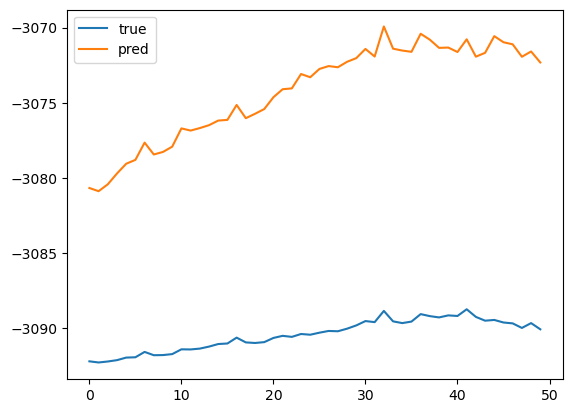

In [50]:
import matplotlib.pyplot as plt
plt.plot(energies_true, label="true")
plt.plot(energies_pred, label="pred")
plt.legend()
plt.show()

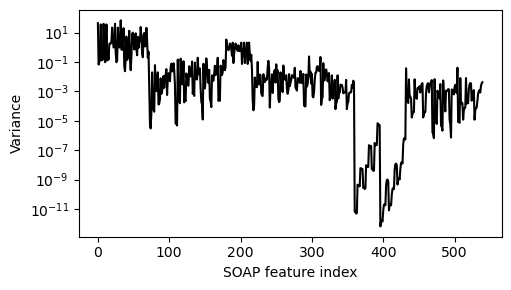

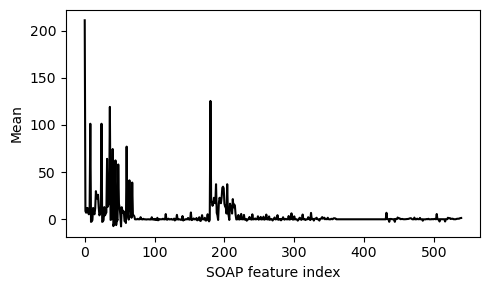

In [297]:
fande_calc.predictor.energy_model.model.model.variational_strategy.inducing_points

# import matplotlib.pyplot as plt

train_x = fande_calc.predictor.energy_model.model.train_x[:].cpu().detach().numpy()
mean_train_x = train_x.mean(axis=0)

train_x_no_mean = train_x - mean_train_x
train_x_variance = train_x_no_mean.var(axis=0)

plt.figure(figsize=(5,3))
plt.plot(train_x_variance, color="black")
plt.xlabel("SOAP feature index")
plt.ylabel("Variance")
plt.tight_layout()
plt.yscale('log')
# plt.xlim(210,215)
# plt.ylim(0,2.0)
# plt.savefig("variance.pdf")
plt.show()


# plt.figure(figsize=(5,3))
# plt.hist(train_x_variance, bins=100, color="black")
# plt.xlabel("Variance")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.yscale('log')
# # plt.savefig("variance_hist.pdf")
# plt.show()

plt.figure(figsize=(5,3))
plt.plot(mean_train_x, color="black")
plt.xlabel("SOAP feature index")
plt.ylabel("Mean")
plt.tight_layout()
# plt.yscale('log')
# plt.savefig("mean.pdf")
plt.show()

# for i in range(0,1000):
#         # plt.plot(fande_calc.predictor.energy_model.model.model.variational_strategy.inducing_points[i].cpu().detach().numpy().flatten())
#         plt.plot(train_x[2*i].flatten() - mean_train_x.flatten())
# # plt.hist(fande_calc.predictor.energy_model.model.train_x.cpu().detach().numpy().flatten(), bins=100)
# # plt.xlim(50, 60)
# plt.show()